# Wind and Solar Suitability Analysis

### Scientific Question Addressed: 
If DAC areas, important farmland, and all areas within proximity to natural areas are excluded from siting, how much land is available for siting? Is there enough land available to reach clean grid goals given capacity expansion projections?

### This notebook calculates the following items referenced in the paper:

* Available Land by State for Wind and Solar under Baseline Exclusions
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of DAC areas
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Important Farmland areas 
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Areas Surrounding Natural Areas (1, 5, 10km distance)
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of DAC areas, Important Farmland, and Areas within 5km of Natural Areas 
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Important Farmland and Areas within 5km of Natural Areas 
* Available Land by State for Wind and Solar under Baseline Exclusions + Exclusion of Important Farmland and Areas within 10km of Natural Areas 


## Raster Data

Most of the raster data used for this analysis is from the GRIDCERF geospatial database v1.0.0, accessible at https://zenodo.org/records/6601790. Additional raster data from GRICERF v2.0.0 was used to supplement the dataset, accessible at: https://doi.org/10.57931/2281697.To prepare data for analysis, all raster data is clipped to the western interconnection boundary extent.

For information on the specific data layers included in the composite layers for DAC areas, Important Farmland, and Natural Area layers, see the `calculate_intersections.ipynb` notebook.

Baseline wind and solar suitability used for this analysis corresponds with data in GRIDCERF v2.0. The GRIDCERF database provides composite technology suitability raster data for renewables based on an assumed capacity factor where areas that are not able to support the indicated capacity factor are unsuitable for siting. The capacity factor layer used for each individual state in the GODEEEP infrastructure experiment is used as the baseline layer in this analysis. 

The suitability layer chosen within the GODEEEP experiment was dynamically determined based on the amount of capacity to be sited in a given state and whether a given suitability layer could support the deployment given the assumed power density of the technology. For example, if 2000 MW of wind needs to be sited in a given state, corresponding to 2000/x square km of land, where x is equal to the power density per square km of wind assumed, and only half the square km of land is suitable at the given capacity factor level, then the next lower capacity factor level is assessed to open up more space. This process is repeated until a suitability layer is chosen such that there is enough land available for siting in a given run year. As a result, states will used different suitability layers for siting. We use the suitability layers used in the GODEEEP experiment for each state for the year 2030 in this analysis, corresponding to a 100m hub height and a power density of 12 MW/square km (3 turbines). The corresponding capacity factors by technology and state are provided in the `state_settings_dict` in this notebook.

The composite rasters for wind include, among other exclusions:

*  all commonly applied protected areas
*  Airports and surrounding areas
*  Areas with slope > 20%
*  NOAA radar stations + a 5 mile buffer
*  Densely populated areas

The composite rasters for solar pv include, among other excluded areas:

*  all commonly applied protected areas
*  Airports
*  Areas with slope > 10%
*  Densely populated areas

For the complete list of data included within the composite Solar PV and Wind layers, refer to the GRIDCERF metadata.

<h2> Methodology</h2>

To identify how much land is available for siting under various conditions, we go through the following steps:
<ol>
    <li> Load raster data for desired evaluation layer (e.g., DAC areas)</li>
    <li> Load raster data corresponding to individual state areas </li>
    <li> Load raster data corresponding to wind or solar suitability for appropriate capacity factor for given state </li>
    <li> Create a composite layer combining evaluation layer(s) and the baseline suitability layer for the given technology</li>
    <li> Using the state raster area, select grid cells only within the given state boundary and sum available area</li>
</ol>

**Note:** To be able to combine multiple rasters (e.g., baseline + DACs), all rasters must have the same shape. The rasters used in this notebook have all been clipped to the western interconnection area. Any additional rasters used with this notebook should be clipped to the same extent.

## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
from shapely import Point

import rasterio
from rasterio.plot import show

import os
from pathlib import Path

## File Paths

In [2]:
# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'input_data')

# output data dir
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'data', 'output_data')

# raster dir
raster_dir = os.path.join(data_dir, 'raster_data')

# state raster path
state_raster_path = os.path.join(raster_dir, 'state_raster', 'state_raster.tif')

# suitability raster dir
suit_dir = os.path.join(raster_dir, 'suitability')

# dac raster path
dac_raster_path = os.path.join(raster_dir, 'disadvantaged_communities', 'west_usceq_combined_vulnerable_communities.tif')

# farmland raster path
farm_raster_path = os.path.join(raster_dir, 'important_farmland', 'west_usda_combined_important_farmland.tif')

# env raster path
env_1km_raster_path = os.path.join(raster_dir, 'environmental', 'onshore_areas_only', 'west_analysis_combined_environment_1buff.tif')
env_5km_raster_path = os.path.join(raster_dir, 'environmental',  'onshore_areas_only','west_analysis_combined_environment_5buff.tif')
env_10km_raster_path = os.path.join(raster_dir, 'environmental',  'onshore_areas_only', 'west_analysis_combined_environment_10buff.tif')

## Functions

In [3]:
def calculate_wind_land_area(exclusion_list, output_dict, tech_type, analysis_name='dac', show_array=True):
    """
    For a given list of raster data, this function combines each of the layers with the assumed baseline 
    suitability raster for the technology indicated (wind or solar). From the composite siting suitability
    layer, a conus state raster is used to subselect areas within each individual state and summing the
    total amount of composite land (km^2) that is available for siting that technology.

    :param exclusion_list:           list of paths to raster data to include in the composite suitability
    :type exclusion_list:            list

    :param output_dict:              prepared dictionary where output should be stored for each state
    :type output_dict:               dict

    :param tech_type:                type of technology being evaluated, solar or wind
    :type tech_type:                 str

    :param analysis_name:            name of specific analysis corresponding to prepared output dictionary
    :type analysis_name:             str

    :param show_array:               if true, will plot the composite siting suitability for the given state
    :type show_array:                bool
    
    
    """
    # open state raster file
    conus_array = rasterio.open(state_raster_path).read(1)
    
    for state in list(output_dict.keys()):
        state_id = state_settings_dict[state]['id_no']
        capacity_factor = state_settings_dict[state][tech_type]

        if tech_type == 'Solar PV':
            suit_file_path = os.path.join(suit_dir, f'gridcerf_solar_pv_centralized_no-cooling_{capacity_factor}cf.tif')
        elif tech_type == 'Wind':
            suit_file_path = os.path.join(suit_dir, f'gridcerf_wind_onshore_hubheight100_no-cooling_{capacity_factor}cf.tif')
        else:
            print('tech_type not supported')
    
        # open suitability file
        suit_array = rasterio.open(suit_file_path).read(1)
        suit_array = np.where(suit_array==1, 1, 0)

        # iterate through raster data in exclusion list and apply to baseline suitability
        for exc in exclusion_list:
            exclusion_array = rasterio.open(exc).read(1)
            exclusion_array = np.where(exclusion_array==1, 1, 0)
    
            suit_array += exclusion_array
            suit_array = np.where(suit_array >= 1, 1, 0)
    
        # invert suitability
        suit_array = np.where(suit_array==1, 0, 1)
    
        # select state area from conus raster
        state_array = np.where(conus_array==state_id, 1, 0)
        
        # calculate state suitability
        suit_array *= state_array
    
        # get sum of available area
        total_area_km = suit_array.sum()
    
        # add available area to output dictionary
        output_dict[state][tech_type][analysis_name] = total_area_km
    
        print(f'{tech_type} suitability under {analysis_name} exclusions within {state} is {total_area_km} square km')

        if show_array:
            show(suit_array)
        else:
            pass
    return None

## Settings

In [4]:
# dictionary of wind capacity factor assumped, solar capacity factor assumed, and id number for each state

state_settings_dict={
    'arizona': {'Wind': 25,'Solar PV': 18, 'id_no': 4},
    'california': {'Wind': 20,'Solar PV': 16, 'id_no': 6},
    'colorado':{'Wind': 30,'Solar PV': 18, 'id_no': 8},
    'idaho':{'Wind': 25,'Solar PV': 14, 'id_no': 16},
    'montana':{'Wind': 30,'Solar PV': 14, 'id_no': 30},
    'new_mexico':{'Wind': 30,'Solar PV': 18, 'id_no': 35},
    'nevada':{'Wind': 25,'Solar PV': 18, 'id_no': 32},
    'oregon':{'Wind': 25, 'Solar PV': 14, 'id_no':41},
    'utah':{'Wind': 25,'Solar PV': 16, 'id_no': 49},
    'washington':{'Wind': 25, 'Solar PV': 12, 'id_no': 53},
    'wyoming':{'Wind': 30,'Solar PV': 14, 'id_no': 56}}


In [5]:
# prepare output dictionary to store analysis values
output_dict={
    'arizona': {},
    'california': {},
    'colorado':{},
    'idaho':{},
    'montana':{},
    'new_mexico':{},
    'nevada':{},
    'oregon':{},
    'utah':{},
    'washington':{},
    'wyoming':{}
}
for state in output_dict:
    output_dict[state].update({'Wind':{}, 'Solar PV': {}})
    
    for i in output_dict[state]:
        output_dict[state][i].update({'baseline':[], 'dac': [], 'farmland':[], 
                                      'env_1km':[], 'env_5km':[], 'env_10km':[], 
                                      'dac_farm_env5km':[], 'farm_env5km':[], 'farm_env10km':[]})

# Wind

## Baseline Siting Availability

How much land is available for siting with no additional restrictions in each state?

Wind suitability under baseline exclusions within arizona is 5477 square km


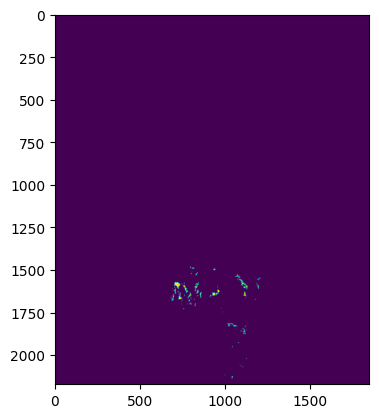

Wind suitability under baseline exclusions within california is 9514 square km


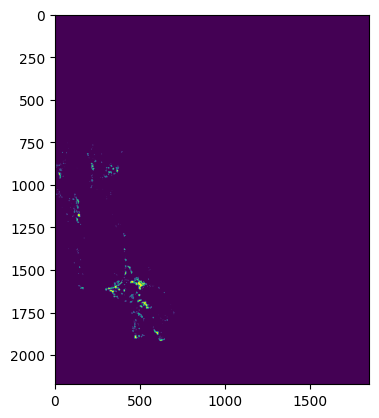

Wind suitability under baseline exclusions within colorado is 34116 square km


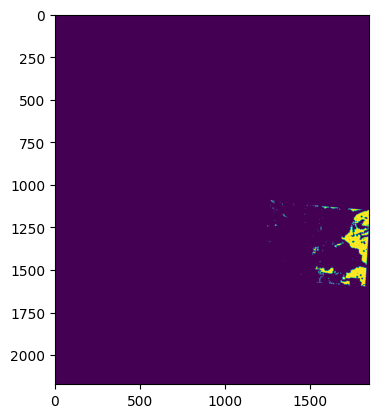

Wind suitability under baseline exclusions within idaho is 3329 square km


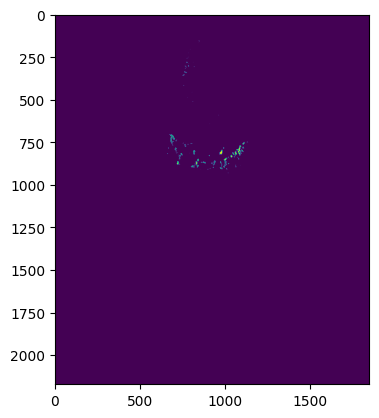

Wind suitability under baseline exclusions within montana is 95935 square km


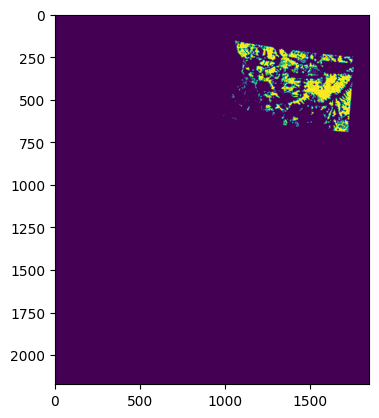

Wind suitability under baseline exclusions within new_mexico is 53510 square km


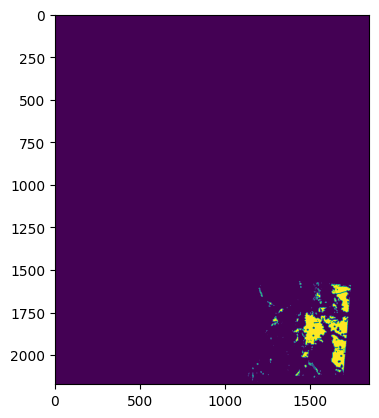

In [ ]:
exclusion_list = []
tech_type = 'Wind'
analysis_name = 'baseline'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=True)

## DAC areas excluded

In [ ]:
exclusion_list = [dac_raster_path]
tech_type = 'Wind'
analysis_name = 'dac'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## Important farmland areas excluded

In [ ]:
exclusion_list = [farm_raster_path]
tech_type = 'Wind'
analysis_name = 'farmland'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## Areas surrounding natural areas excluded

### Areas within 1-km

In [ ]:
exclusion_list = [env_1km_raster_path]
tech_type = 'Wind'
analysis_name = 'env_1km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

### Areas within 5-km

In [ ]:
exclusion_list = [env_5km_raster_path]
tech_type = 'Wind'
analysis_name = 'env_5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

### Areas within 10-km

In [ ]:
exclusion_list = [env_10km_raster_path]
tech_type = 'Wind'
analysis_name = 'env_10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## Combinations

#### DACs, Important Farmland, and Areas within 5km of Natural Areas Excluded

In [ ]:
exclusion_list = [dac_raster_path, farm_raster_path, env_5km_raster_path]
tech_type = 'Wind'
analysis_name = 'dac_farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

#### Important Farmland, and Areas within 5km of Natural Areas Excluded

In [ ]:
exclusion_list = [farm_raster_path, env_5km_raster_path]
tech_type = 'Wind'
analysis_name = 'farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

#### Important Farmland, and Areas within 10km of Natural Areas Excluded

In [ ]:
exclusion_list = [farm_raster_path, env_10km_raster_path]
tech_type = 'Wind'
analysis_name = 'farm_env10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

________

# Solar PV

## Baseline Siting Availability

How much land is available for siting with no additional restrictions in each state?

In [ ]:
exclusion_list = []
tech_type = 'Solar PV'
analysis_name = 'baseline'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## DAC areas excluded

In [ ]:
exclusion_list = [dac_raster_path]
tech_type = 'Solar PV'
analysis_name = 'dac'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## Important farmland areas excluded

In [ ]:
exclusion_list = [farm_raster_path]
tech_type = 'Solar PV'
analysis_name = 'farmland'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## Areas surrounding natural areas excluded

### Areas within 1-km

In [ ]:
exclusion_list = [env_1km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'env_1km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

### Areas within 5-km

In [ ]:
exclusion_list = [env_5km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'env_5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

### Areas within 10-km

In [ ]:
exclusion_list = [env_10km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'env_10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

## Combinations

#### DACs, Important Farmland, and Areas within 5km of Natural Areas Excluded

In [ ]:
exclusion_list = [dac_raster_path, farm_raster_path, env_5km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'dac_farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

#### Important Farmland, and Areas within 5km of Natural Areas Excluded

In [ ]:
exclusion_list = [farm_raster_path, env_5km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'farm_env5km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

#### Important Farmland, and Areas within 10km of Natural Areas Excluded

In [ ]:
exclusion_list = [farm_raster_path, env_10km_raster_path]
tech_type = 'Solar PV'
analysis_name = 'farm_env10km'

calculate_wind_land_area(exclusion_list=exclusion_list, output_dict=output_dict, 
                         tech_type=tech_type, analysis_name=analysis_name, show_array=False)

___________

## Prepare Output

In [ ]:
# convert output dictionary to dataframe
df = pd.DataFrame.from_dict({(i,j): output_dict[i][j] 
                           for i in output_dict.keys() 
                           for j in output_dict[i].keys()},
                       orient='index')

df = df.reset_index().rename(columns={'level_0':'region_name', 'level_1':'tech_name_simple'})
df

### Collect land actually used by wind and solar in each experiment scenario

In [ ]:
# infrastructure siting output csv
infrastucture_path = os.path.join(data_dir,  'infrastructure_data_csv', 'infrastructure_data.csv')

# collect infrastructure data
sitings_df = pd.read_csv(infrastucture_path)

# select new infrastructure sitings only
sitings_df = sitings_df[sitings_df.cerf_sited == 1]

# select wind and solar only
sitings_df = sitings_df[sitings_df.tech_name_simple.isin(['Solar PV', 'Wind'])]

# collect the total land usage used by solar and wind by state and scenario
sitings_df = sitings_df[['scenario', 'region_name', 'tech_name_simple', 'xcoord']].groupby(['scenario', 'region_name', 'tech_name_simple'], 
                                                                                           as_index=False).count()
# shorten scenario names
sitings_df.scenario.replace('business_as_usual_ira_ccs_climate', 'bau_km', inplace=True)
sitings_df.scenario.replace('net_zero_ira_ccs_climate', 'clean_grid_km', inplace=True)

#Pivoting dataframe
sitings_df = pd.pivot_table(sitings_df, values='xcoord', index=['region_name', 'tech_name_simple'], columns=['scenario'], aggfunc=np.sum)
sitings_df = sitings_df.reset_index()
sitings_df = sitings_df.rename_axis(None, axis=1)
sitings_df

##### Combine dataframes and save to file

In [ ]:
output_df = pd.merge(df, sitings_df, how='left', on=['region_name', 'tech_name_simple'])

In [ ]:
# output file path
output_path = os.path.join(output_dir, 'suitability_analysis.csv')

output_df.to_csv(output_path, index=False)